SDGRegressor to predict Crowdness at the gym


In [6]:
pip install --user numpy==1.25.0

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
%matplotlib inline

In [10]:
df = pd.read_csv("crowdness_gym_data.csv")

In [11]:
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [13]:
df.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

In [14]:
df = df.drop('date',axis=1)

In [15]:
df.head()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,61211,4,0,0,71.76,0,0,8,17
1,45,62414,4,0,0,71.76,0,0,8,17
2,40,63015,4,0,0,71.76,0,0,8,17
3,44,63616,4,0,0,71.76,0,0,8,17
4,45,64217,4,0,0,71.76,0,0,8,17


Exploratory data analysis: Let's graph in a histogram day_of_week,month and hour

Text(0, 0.5, 'No. of observations')

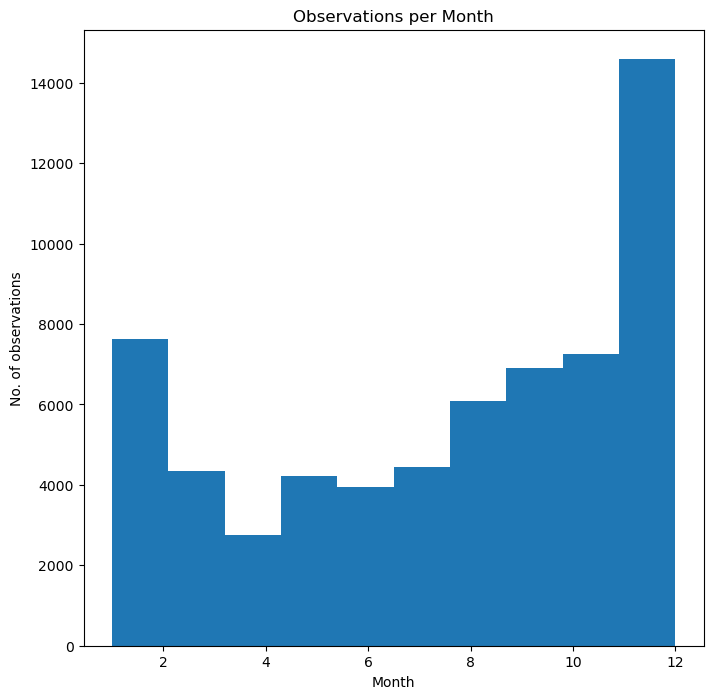

In [17]:
plt.figure(figsize=(8,8))

plt.hist(df['month'])
plt.title('Observations per Month')
plt.xlabel('Month')
plt.ylabel('No. of observations')

We can see that december is the highest ocurrance month

Text(0, 0.5, 'No. of observations')

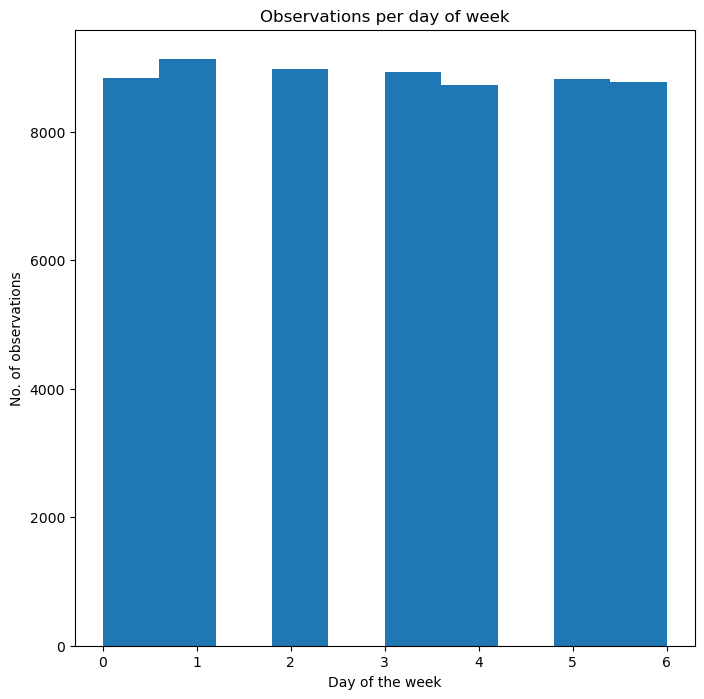

In [18]:
plt.figure(figsize=(8,8))

plt.hist(df['day_of_week'])
plt.title('Observations per day of week')
plt.xlabel('Day of the week')
plt.ylabel('No. of observations')

Let's plot it using seaborn as this graph doesn't show a lot

Text(-3.9305555555555554, 0.5, 'No. of observations')

<Figure size 800x800 with 0 Axes>

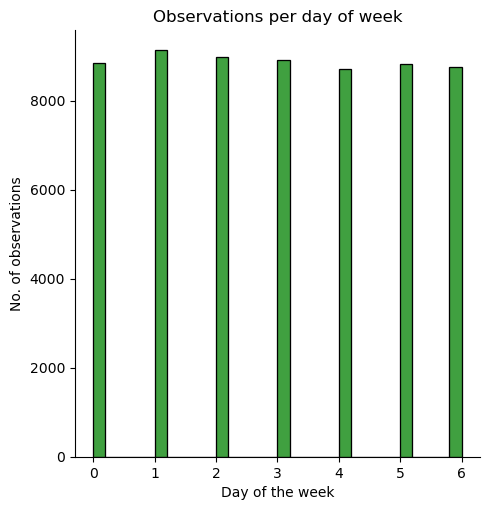

In [19]:
plt.figure(figsize = (8,8))

sns.displot(df['day_of_week'],color = 'g')
plt.title('Observations per day of week')
plt.xlabel('Day of the week')
plt.ylabel('No. of observations')


It is pretty constant across the week, no day is higher or lower. Maybe Tuesday

Text(0, 0.5, 'No. of observations')

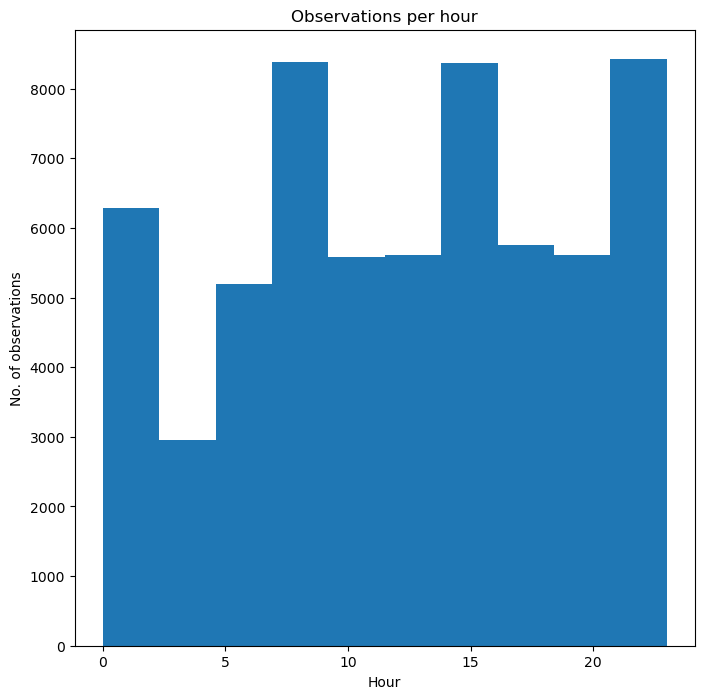

In [20]:
plt.figure(figsize=(8,8))

plt.hist(df['hour'])
plt.title('Observations per hour')
plt.xlabel('Hour')
plt.ylabel('No. of observations')

Surpirse that at midnight people use the Gym!

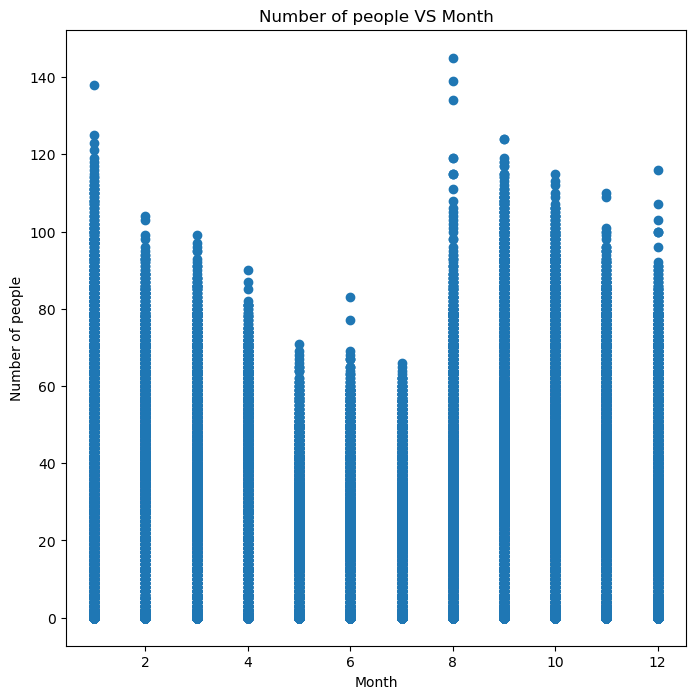

In [22]:
#Bivariate analysis for better correlation analysis between time and number of people
plt.figure(figsize = (8,8))

plt.scatter(df['month'],df['number_people'])
plt.title('Number of people VS Month')
plt.xlabel('Month')
plt.ylabel('Number of people')
plt.show()

Here we see the previous suspects plus August, that is the first month of the semester, plus we see that December is not as big as in the previous graph

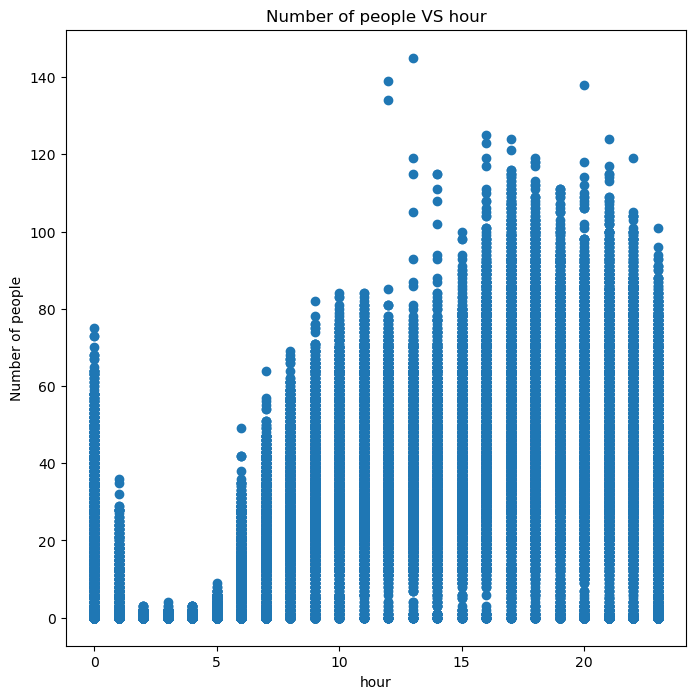

In [23]:
#Let's look at the hours
plt.figure(figsize = (8,8))

plt.scatter(df['hour'],df['number_people'])
plt.title('Number of people VS hour')
plt.xlabel('hour')
plt.ylabel('Number of people')
plt.show()

Lunch time and late afternoon are the peaks, let's start the correlation between columns to start developing the model

In [24]:
df.corr()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
number_people,1.000000,0.550218,-0.162062,-0.173958,-0.048249,0.373327,0.182683,0.335350,-0.097854,0.552049
timestamp,0.550218,1.000000,-0.001793,-0.000509,0.002851,0.184849,0.009551,0.044676,-0.023221,0.999077
day_of_week,-0.162062,-0.001793,1.000000,0.791338,-0.075862,0.011169,-0.011782,-0.004824,0.015559,-0.001914
is_weekend,-0.173958,-0.000509,0.791338,1.000000,-0.031899,0.020673,-0.016646,-0.036127,0.008462,-0.000517
is_holiday,-0.048249,0.002851,-0.075862,-0.031899,1.000000,-0.088527,-0.014858,-0.070798,-0.094942,0.002843
temperature,0.373327,0.184849,0.011169,0.020673,-0.088527,1.000000,0.093242,0.152476,0.063125,0.185121
is_start_of_semester,0.182683,0.009551,-0.011782,-0.016646,-0.014858,0.093242,1.000000,0.209862,-0.137160,0.010091
is_during_semester,0.335350,0.044676,-0.004824,-0.036127,-0.070798,0.152476,0.209862,1.000000,0.096556,0.045581
month,-0.097854,-0.023221,0.015559,0.008462,-0.094942,0.063125,-0.137160,0.096556,1.000000,-0.023624
hour,0.552049,0.999077,-0.001914,-0.000517,0.002843,0.185121,0.010091,0.045581,-0.023624,1.000000


<AxesSubplot:>

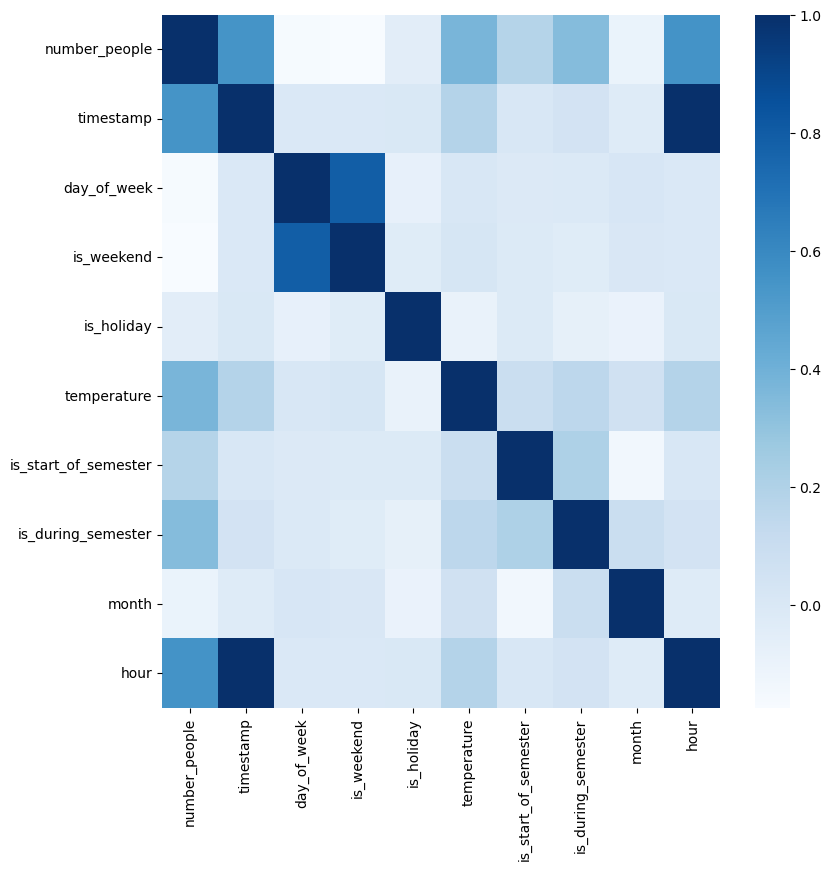

In [25]:
#Let's look at it in a heatmap for better visualization
plt.figure(figsize = (9,9))
sns.heatmap(df.corr(), cmap = 'Blues')

The higher correlations with number of people (our relevant variable) are: temperature, hour, timestamp (redundant with hour column so we will drop it) and is_during_semester

In [26]:
df = df.drop('timestamp',axis = 1)
df.head()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,4,0,0,71.76,0,0,8,17
1,45,4,0,0,71.76,0,0,8,17
2,40,4,0,0,71.76,0,0,8,17
3,44,4,0,0,71.76,0,0,8,17
4,45,4,0,0,71.76,0,0,8,17


Now that we have the target variable and the relevant features let's prepare the data for training the Stochastic Gradient descent model. First let's split the data for training 70% and test 30%

In [28]:
data = df.values
X = data[:,1:] #The values removing number of people column and column names
y = data[:,0] #The column values for number_people

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)

In [29]:
#Let's review the sizes for the training and test data
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Testing label shape: {y_test.shape}")

Training features shape: (43528, 8)
Testing features shape: (18656, 8)
Training label shape: (43528,)
Testing label shape: (18656,)


Now let's build the model object SGDRegressor. Setting learning rate to optimal and the loss function to squared_error loss and using elasticnet for penalty

In [32]:
sgd_v1 = SGDRegressor(alpha=0.0001,learning_rate = 'optimal',loss='squared_error',penalty='elasticnet',random_state = 52)

In [33]:
sgd_v1.fit(X_train,y_train)

SGDRegressor(learning_rate='optimal', penalty='elasticnet', random_state=52)

Measure the model performance

In [34]:
y_pred_v1 = sgd_v1.predict(X_test)

In [36]:
#Now let's evaluate the model performance
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
# The mean squared error
print(f"Mean squared error: {round( mean_squared_error(y_test, y_pred_v1),3)}")
# Explained variance score: 1 is perfect prediction
print(f"R2 score: {round(r2_score(y_test, y_pred_v1),3)}")
# Mean Absolute Error
print(f"Mean absolute error: { round(mean_absolute_error(y_test, y_pred_v1),3)}")

Mean squared error: 283.447
R2 score: 0.45
Mean absolute error: 13.221


It is not doing so well, let's try scale the features to see if the model can achieve better accuracy

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
#Let's use the scaled data for another model
sgd_v2 = SGDRegressor(alpha = 0.0001,learning_rate = 'optimal',penalty='elasticnet',random_state = 52)


In [39]:
sgd_v2.fit(X_train_scaled,y_train)

SGDRegressor(learning_rate='optimal', penalty='elasticnet', random_state=52)

In [40]:
y_pred_v2 = sgd_v2.predict(X_test_scaled)

In [41]:
# The mean squared error
print(f"Mean squared error: {round( mean_squared_error(y_test, y_pred_v2),3)}")
# Explained variance score: 1 is perfect prediction
print(f"R2 score: {round(r2_score(y_test, y_pred_v2),3)}")
# Mean Absolute Error
print(f"Mean absolute error: { round(mean_absolute_error(y_test, y_pred_v2),3)}")

Mean squared error: 259.042
R2 score: 0.497
Mean absolute error: 12.204


Visualize the results of our model: Using a line plot for actual test data and predicted data

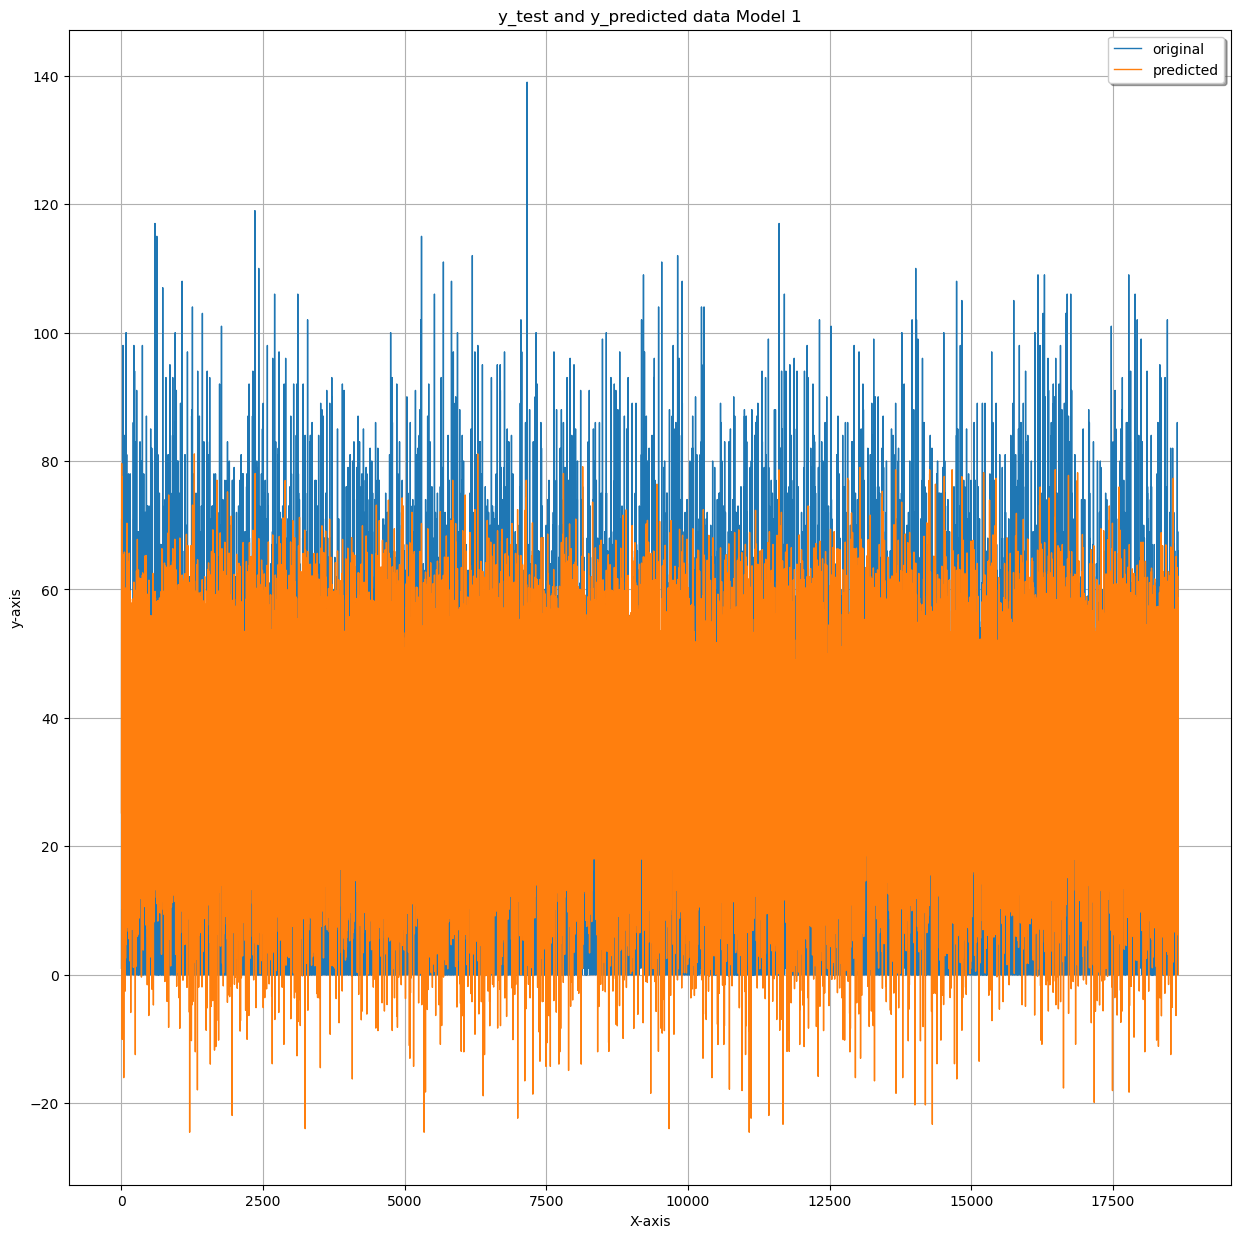

In [43]:
plt.figure(figsize=(15,15))

x_ax = range(len(y_test))
plt.plot(x_ax,y_test,linewidth=1,label='original')
plt.plot(x_ax,y_pred_v1,linewidth=1,label='predicted')
plt.title('y_test and y_predicted data Model 1')
plt.xlabel('X-axis')
plt.ylabel('y-axis')
plt.legend(loc='best',fancybox=True,shadow=True)
plt.grid(True)
plt.show()

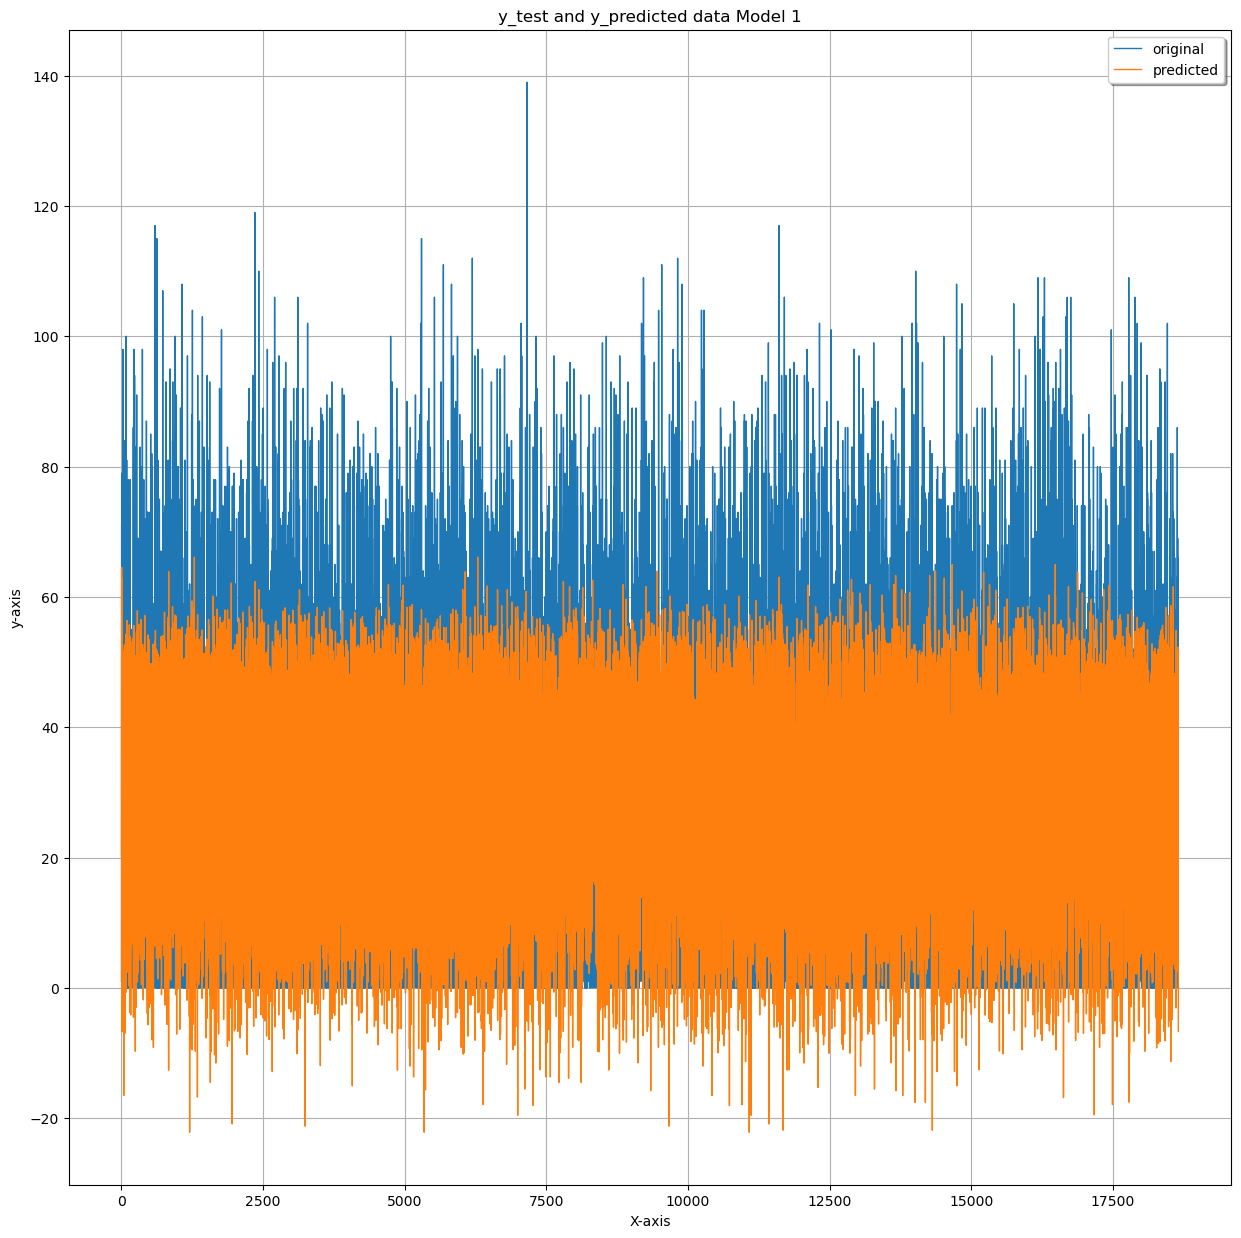

In [44]:
plt.figure(figsize=(15,15))

x_ax = range(len(y_test))
plt.plot(x_ax,y_test,linewidth=1,label='original')
plt.plot(x_ax,y_pred_v2,linewidth=1,label='predicted')
plt.title('y_test and y_predicted data Model 1')
plt.xlabel('X-axis')
plt.ylabel('y-axis')
plt.legend(loc='best',fancybox=True,shadow=True)
plt.grid(True)
plt.show()